In [ ]:
!pwd
import os
os.chdir("Projects/crop-care/")
!pwd

In [ ]:
from datasets import load_dataset
import PIL.Image
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForImageClassification, MobileNetV2Config, MobileNetV2ForImageClassification
from transformers import DefaultDataCollator

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from huggingface_hub import notebook_login
import evaluate

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from tqdm.auto import tqdm
import warnings

In [1]:
dataset = load_dataset("beans")
dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

class names: ['angular_leaf_spot', 'bean_rust', 'healthy']


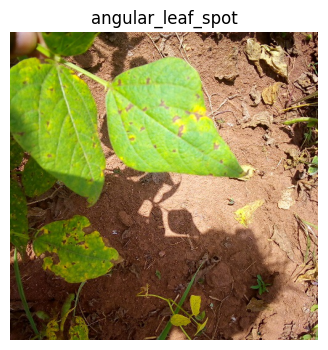

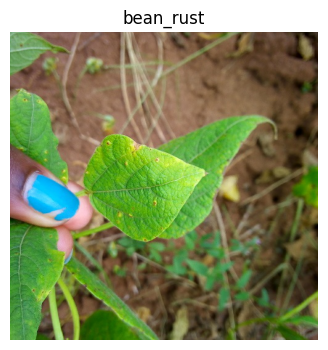

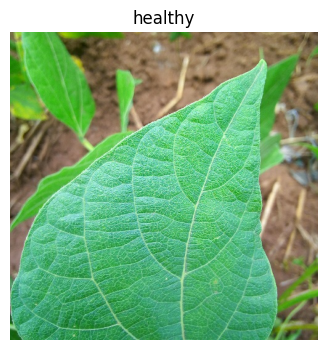

In [3]:

class_names = dataset['train'].features['labels'].names
print(f'class names: {class_names}')

unique_labels = sorted(dataset["train"].unique("labels"))

for label in unique_labels:
    index = dataset["train"]["labels"].index(label)  

    image = dataset["train"]["image"][index]
    label_name = class_names[label]

    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(label_name)
    plt.axis("off")
    plt.show()

In [4]:
id2label = {i: name for i, name in zip(unique_labels, class_names)}
label2id = {v:k for k, v in id2label.items()}
num_classes = len(label2id)

In [5]:
teacher_processor = AutoImageProcessor.from_pretrained('merve/beans-vit-224')

def process(examples):
    return teacher_processor(examples['image'])

processed_dataset_train = dataset['train'].map(process, batched=True, remove_columns=['image_file_path', 'image'])
processed_dataset_val = dataset['validation'].map(process, batched=True, remove_columns = ['image_file_path', 'image'])
processed_dataset_test = dataset['test'].map(process, batched=True, remove_columns = ['image_file_path', 'image'])  

In [6]:
class TrainingModule(Trainer):
    def __init__(self, student_model=None, teacher_model=None, temperature=None, lambda_parameter=None, *args, **kwargs):
        super().__init__(model=student_model, *args, **kwargs)
        self.student_model = student_model
        self.teacher_model = teacher_model
        self.loss_fn = nn.KLDivLoss(reduction='batchmean')
        self.clf_loss = nn.CrossEntropyLoss()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.teacher_model.to(device)
        self.teacher_model.eval()
        self.temperature = temperature
        self.lambda_parameter = lambda_parameter
        
    def compute_loss(self, student, inputs, return_outputs=False):
        student_output = self.student_model(**inputs)
        
        with torch.no_grad():
            teacher_output = self.teacher_model(**inputs)

        soft_teacher = F.softmax(teacher_output.logits / self.temperature, dim=-1)
        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)
        
        distillation_loss = self.loss_fn(soft_student, soft_teacher) * (self.temperature ** 2)
        student_target_loss = self.clf_loss(student_output.logits, inputs['labels'])

        loss = (1 - self.lambda_parameter) * student_target_loss + self.lambda_parameter * distillation_loss
        
        return (loss, student_output) if return_outputs else loss
        

In [7]:
notebook_login()

In [12]:
repo_name = 'distilled-vit-beans'

training_args = TrainingArguments(
    output_dir = 'distilled-vit-beans',
    num_train_epochs=5,
    fp16=True,
    logging_dir=f'{repo_name}/logs',
    per_device_train_batch_size=1024,
    per_device_eval_batch_size=64,
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='wandb',
    hub_strategy="every_save",
    hub_model_id=repo_name
)

num_labels = len(dataset['train'].features['labels'].names)

teacher_model = AutoModelForImageClassification.from_pretrained(
    'merve/beans-vit-224',
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

# student_config = MobileNetV2Config(num_labels=num_labels)
# student_model = MobileNetV2ForImageClassification(student_config)
model_name = "facebook/deit-small-patch16-224" 
student_model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

/soft/AIDL/conda_envs/pytorch-200/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([3, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
accuracy=evaluate.load('accuracy')
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    acc =  accuracy.compute(references=labels, predictions=np.argmax(preds, axis=-1))
    return {
        'accuracy': acc['accuracy']
    }

In [14]:
data_collator = DefaultDataCollator()
trainer = TrainingModule(
    student_model=student_model,
    teacher_model=teacher_model,
    temperature=5,
    lambda_parameter=0.5,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset_train,
    eval_dataset=processed_dataset_val,
    tokenizer=teacher_processor,
    data_collator=data_collator,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.888900,0.685838,0.654135
2,0.632400,0.541997,0.781955
3,0.457600,0.448559,0.729323
4,0.418300,0.408292,0.774436
5,0.387200,0.394114,0.766917


Checkpoint destination directory distilled-vit-beans/checkpoint-2 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilled-vit-beans/checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=10, training_loss=0.5568658947944641, metrics={'train_runtime': 351.3816, 'train_samples_per_second': 14.713, 'train_steps_per_second': 0.028, 'total_flos': 1.0117058010200064e+17, 'train_loss': 0.5568658947944641, 'epoch': 5.0})

In [16]:
torch.save(student_model.state_dict(), "./distilled-vit-beans/student_model.pth")

In [17]:
trainer.evaluate(eval_dataset = processed_dataset_test)       

{'eval_loss': 0.5462092757225037,
 'eval_accuracy': 0.765625,
 'eval_runtime': 8.0446,
 'eval_samples_per_second': 15.911,
 'eval_steps_per_second': 0.249,
 'epoch': 5.0}

In [42]:
warnings.filterwarnings("ignore")

def evaluate_student_model(model, eval_dataset, data_collator, device="cuda"):
    model.to(device)
    model.eval()

    preds = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(eval_dataset):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            logits = outputs.logits
            predictions = np.argmax(logits.detach().cpu().numpy(), axis=-1)
            preds.extend(predictions)
            labels.extend(batch["labels"].detach().cpu().numpy())

    accuracy = np.mean(preds == labels)
    f1 = f1_score(labels, preds, average='macro') 
    report = classification_report(labels, preds, zero_division=0)

    cm = confusion_matrix(labels, preds) 
    return accuracy, f1, report, cm

def draw_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def show_predictions(model, dataset, class_names, num_samples=5, device="cuda"):
    model.to(device)
    model.eval()

    rand_indices = np.random.choice(len(dataset), num_samples, replace=False).tolist()

    for index in rand_indices:
        image = dataset[index]["pixel_values"]
        label = dataset[index]["labels"]
        true_label_name = class_names[label]

        input_batch = data_collator([dataset[index]]) 
        # print(input_batch)
        input_batch = {k: v.to(device) for k, v in input_batch.items()}

        with torch.no_grad():
            output = model(**input_batch)
            pred_label = np.argmax(output.logits.detach().cpu().numpy())
            pred_label_name = class_names[pred_label]

        color = "green" if pred_label == label else "red"
        image = np.transpose(image, (1, 2, 0))
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(f"True Label: {true_label_name}\nPredicted Label: {pred_label_name}", color=color)
        plt.axis("off")
        plt.show()

test_dataloader = DataLoader(processed_dataset_val, batch_size=64, collate_fn=data_collator)


In [20]:
accuracy, f1, report, cm = evaluate_student_model(student_model, test_dataloader, data_collator)
print(f"F1-Score: {f1:.4f}")
print(report)


  0%|          | 0/3 [00:00<?, ?it/s]

F1-Score: 0.7782
              precision    recall  f1-score   support

           0       0.81      0.66      0.73        44
           1       0.79      0.76      0.77        45
           2       0.76      0.93      0.84        44

    accuracy                           0.78       133
   macro avg       0.79      0.78      0.78       133
weighted avg       0.79      0.78      0.78       133



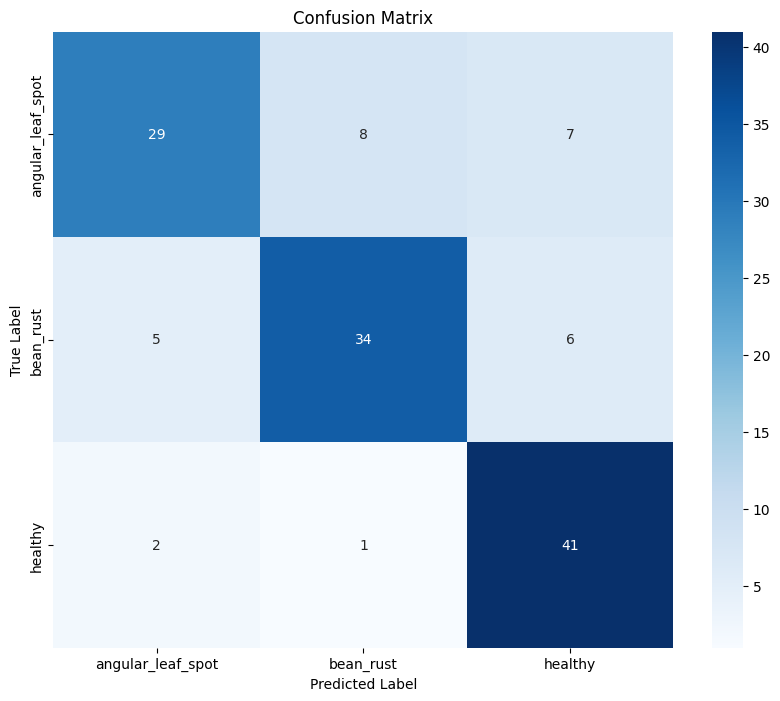

In [21]:
draw_confusion_matrix(cm, class_names) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


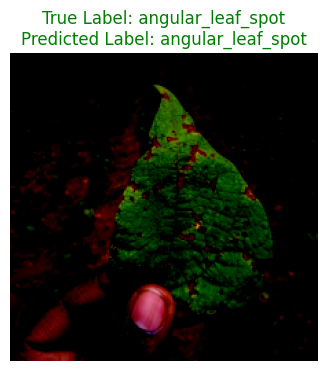

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


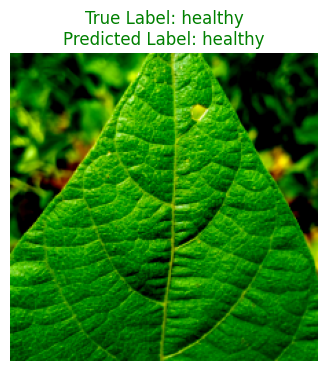

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


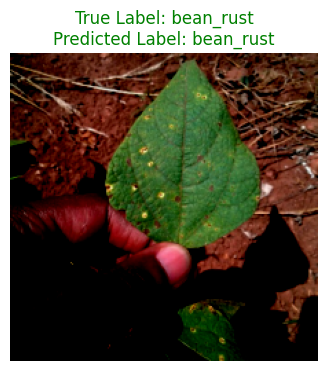

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


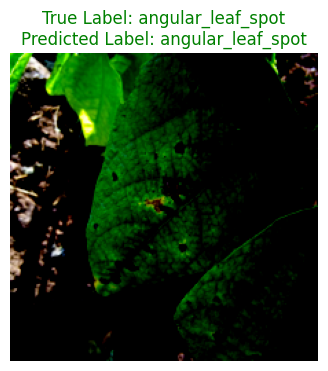

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


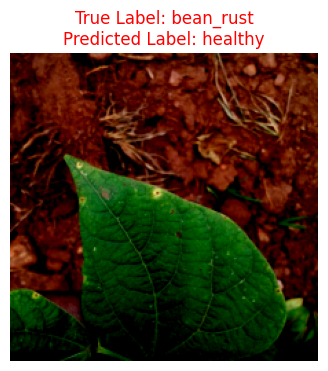

In [43]:
show_predictions(student_model, processed_dataset_val, class_names) 

In [60]:
def compare_model_results(student_model, teacher_model, eval_dataset, data_collator, device="cuda"):

  teacher_model.to(device)
  teacher_model.eval()
  eval_dataloader = DataLoader(eval_dataset, batch_size=8, collate_fn = data_collator)
  with torch.no_grad():
      preds = []
      labels = []
      
      for batch in eval_dataloader:
          label = batch['labels']
          
          batch = {k: v.to('cuda') for k, v in batch.items() if k != 'labels'}
          outputs = teacher_model(pixel_values=batch['pixel_values'])
          logits = outputs.logits
          predictions = np.argmax(logits.detach().cpu().numpy(), axis=-1)
          preds.extend(predictions)
          labels.extend(label.detach().cpu().numpy())

  teacher_accuracy = np.mean(preds == labels)
  teacher_f1 = f1_score(labels, preds, average='weighted') 

  results = {
      "student_f1": 0.7782,
      "teacher_f1": teacher_f1
  }

  return results
  
compare_model_results(student_model, teacher_model, processed_dataset_val, data_collator, device="cuda")

{'student_f1': 0.7782, 'teacher_f1': 0.9698486337424107}